In [1]:
import os
import shutil

mount_point = '/content/drive'

# Check if the directory exists and is not empty
if os.path.isdir(mount_point) and os.listdir(mount_point):
    print(f"Clearing the mount point directory: {mount_point}")
    try:
        # Remove all contents of the directory
        for item in os.listdir(mount_point):
            item_path = os.path.join(mount_point, item)
            if os.path.isfile(item_path):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        print("Mount point directory cleared.")
    except Exception as e:
        print(f"Error clearing mount point directory: {e}")
else:
    print(f"Mount point directory {mount_point} is already empty or does not exist.")

# Attempt to mount Google Drive again
from google.colab import drive
try:
    drive.mount(mount_point)
    print("Google Drive mounted successfully.")
except ValueError as e:
    print(f"Error mounting Google Drive: {e}")

Mount point directory /content/drive is already empty or does not exist.
Mounted at /content/drive
Google Drive mounted successfully.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import gc
gc.enable()

In [4]:
import os
import cv2
import numpy as np
import pathlib
import gc

base_classification_dir = pathlib.Path("/content/drive/MyDrive/pest_classifier/classification")

# Select only 5 categories for training
selected_category_names = [
    "rice leaf roller",
    "rice leaf caterpillar",
    "paddy stem maggot",
    "asiatic rice borer",
    "yellow rice borer"
]

directory_names = [str(i) for i in range(0, 102)]

train_dir = base_classification_dir / "train"
validation_dir = base_classification_dir / "val"
test_dir = base_classification_dir / "test"


print("\nDataset Paths Defined.")
print(f"Training data path: {train_dir}")
print(f"Validation data path: {validation_dir}")
print(f"Test data path: {test_dir}")


Dataset Paths Defined.
Training data path: /content/drive/MyDrive/pest_classifier/classification/train
Validation data path: /content/drive/MyDrive/pest_classifier/classification/val
Test data path: /content/drive/MyDrive/pest_classifier/classification/test


In [5]:
import psutil
print(f"Memory used: {psutil.virtual_memory().percent}%")


Memory used: 10.7%


In [6]:
import os

train_dir = "/content/drive/MyDrive/pest_classifier/classification/train"
folders = sorted(os.listdir(train_dir))
print("Folders found:", folders)
print("Total folders:", len(folders))


Folders found: ['0', '1', '10', '100', '101', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
Total folders: 102


In [7]:
# Define image size and batch size
img_size = 224
batch_size = 32

print(f"Image size set to: {img_size}x{img_size}")
print(f"Batch size set to: {batch_size}")

Image size set to: 224x224
Batch size set to: 32


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50, MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [12]:
import os

# Function to count images in each category within a directory
def count_images_in_categories(directory, category_names):
    counts = {}
    full_directory_names = [str(i) for i in range(0, 102)]
    category_to_original_index = {name: full_directory_names.index(str(i)) for i, name in enumerate(selected_category_names)}

    for category_name in category_names:
        if category_name in category_to_original_index:
            original_index = category_to_original_index[category_name]
            category_dir = os.path.join(directory, str(original_index))
            if os.path.exists(category_dir):
                num_images = len([f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))])
                counts[category_name] = num_images
            else:
                counts[category_name] = 0 # Category directory not found
        else:
             counts[category_name] = 0 # Category name not in selected_category_names


    return counts

# Count images for each dataset
train_counts = count_images_in_categories(train_dir, selected_category_names)
val_counts = count_images_in_categories(validation_dir, selected_category_names)
test_counts = count_images_in_categories(test_dir, selected_category_names)

print("Image counts per category in Training set:")
print(train_counts)

print("\nImage counts per category in Validation set:")
print(val_counts)

print("\nImage counts per category in Test set:")
print(test_counts)

Image counts per category in Training set:
{'rice leaf roller': 669, 'rice leaf caterpillar': 292, 'paddy stem maggot': 156, 'asiatic rice borer': 631, 'yellow rice borer': 302}

Image counts per category in Validation set:
{'rice leaf roller': 111, 'rice leaf caterpillar': 48, 'paddy stem maggot': 26, 'asiatic rice borer': 106, 'yellow rice borer': 50}

Image counts per category in Test set:
{'rice leaf roller': 335, 'rice leaf caterpillar': 147, 'paddy stem maggot': 79, 'asiatic rice borer': 316, 'yellow rice borer': 152}


In [10]:
from sklearn.utils import class_weight
import numpy as np


train_counts = {'rice leaf roller': 669, 'rice leaf caterpillar': 292, 'paddy stem maggot': 156, 'asiatic rice borer': 631, 'yellow rice borer': 302}
selected_category_names = [
    "rice leaf roller",
    "rice leaf caterpillar",
    "paddy stem maggot",
    "asiatic rice borer",
    "yellow rice borer"
]
# Create a list of all labels based on the counts
all_labels = []
for i, category_name in enumerate(selected_category_names):
    all_labels.extend([i] * train_counts[category_name])

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(all_labels),
    y=all_labels
)

# Convert to a dictionary
class_weight_dict = dict(enumerate(class_weights))

print("Calculated class weights:")
print(class_weight_dict)


resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

print("Models compiled successfully.")

Calculated class weights:
{0: np.float64(0.6128550074738416), 1: np.float64(1.404109589041096), 2: np.float64(2.628205128205128), 3: np.float64(0.6497622820919176), 4: np.float64(1.3576158940397351)}


NameError: name 'resnet_model' is not defined

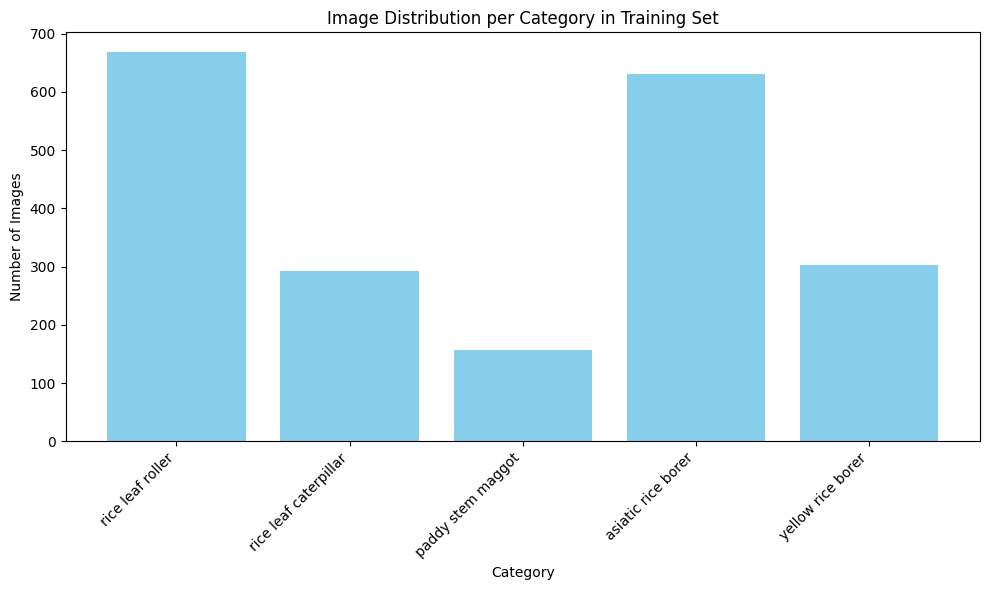

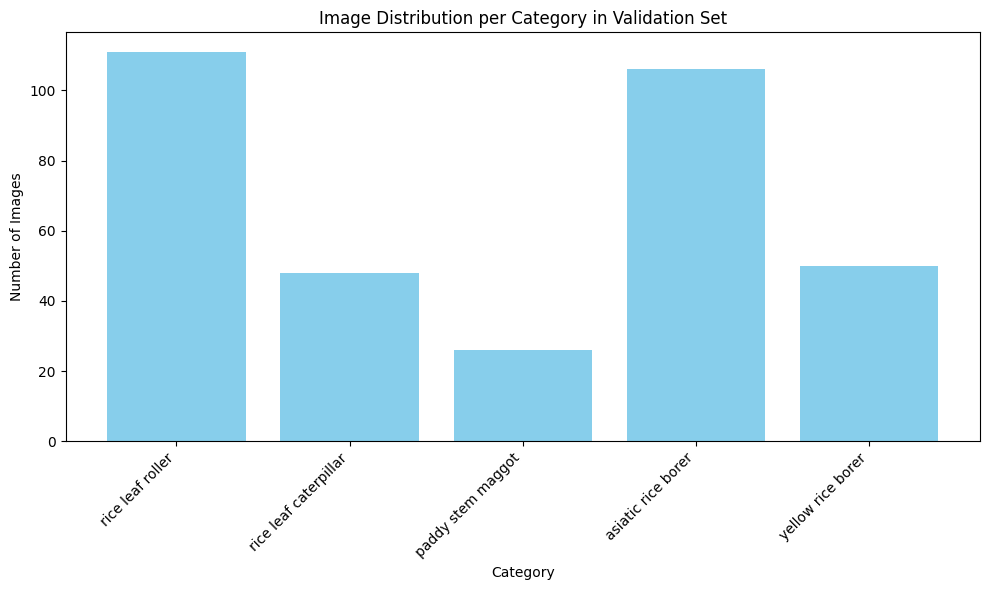

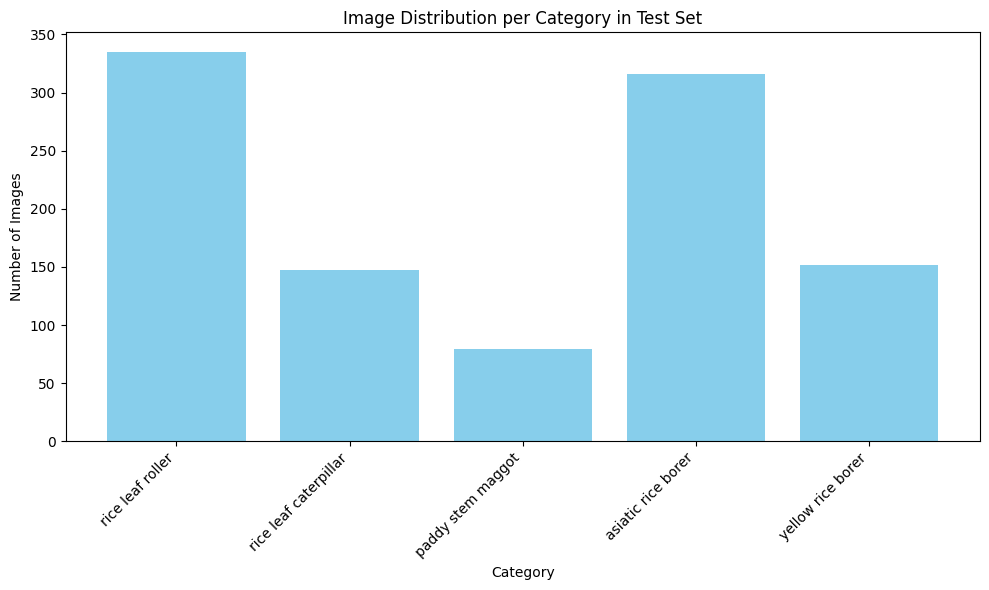

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_category_distribution(counts, dataset_name):
    """Plots a bar chart of image counts per category."""
    categories = list(counts.keys())
    image_counts = list(counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(categories, image_counts, color='skyblue')
    plt.xlabel("Category")
    plt.ylabel("Number of Images")
    plt.title(f"Image Distribution per Category in {dataset_name} Set")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot distributions for each dataset
plot_category_distribution(train_counts, "Training")
plot_category_distribution(val_counts, "Validation")
plot_category_distribution(test_counts, "Test")

In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness

# Define the data augmentation pipeline
data_augmentation = Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(factor=0.2),
], name="data_augmentation")

def load_and_preprocess_image(image_path, label, augment=False):
    """Loads and preprocesses an image, optionally applying augmentation."""
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = img / 255.0 # Normalize to [0, 1]
    if augment:
        img = data_augmentation(img, training=True) # Apply augmentation during training
    return img, label

def create_dataset(directory, category_names, shuffle=True, augment=False):
    """Creates a tf.data.Dataset from image files in a directory."""
    image_paths = []
    labels = []
    full_directory_names = [str(i) for i in range(0, 102)]
    category_to_original_index = {name: full_directory_names.index(str(i)) for i, name in enumerate(selected_category_names)}

    for i, category in enumerate(category_names):
        if category in category_to_original_index:
            original_index = category_to_original_index[category]
            category_dir = os.path.join(directory, str(original_index))
            if os.path.exists(category_dir):
                for img_name in os.listdir(category_dir):
                    image_paths.append(os.path.join(category_dir, img_name).encode('utf-8'))
                    labels.append(i)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    # Use lambda to pass the 'augment' parameter to load_and_preprocess_image
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)

    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

# Recreate the train_dataset with augmentation
train_dataset = create_dataset(train_dir, selected_category_names, augment=True)

# Recreate validation and test datasets without augmentation
val_dataset = create_dataset(validation_dir, selected_category_names, shuffle=False, augment=False)
test_dataset = create_dataset(test_dir, selected_category_names, shuffle=False, augment=False)

print("Data augmentation pipeline defined.")
print("tf.data.Dataset created/recreated with augmentation for training set.")
print("Validation and test datasets created/recreated without augmentation.")

Data augmentation pipeline defined.
tf.data.Dataset created/recreated with augmentation for training set.
Validation and test datasets created/recreated without augmentation.


## Define resnet model

### Subtask:
Build a ResNet model using pre-trained weights (e.g., ResNet50, ResNet101) and add custom layers for your classification task.


**Reasoning**:
Build the ResNet model according to the instructions.



In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50

base_resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers initially
for layer in base_resnet_model.layers:
    layer.trainable = False

x = base_resnet_model.output

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

# Update the output layer to have the number of selected categories
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)

resnet_model = models.Model(inputs=base_resnet_model.input, outputs=predictions)

fine_tune_at = len(base_resnet_model.layers) - 20 # Unfreeze the last 20 layers as a starting point

for layer in base_resnet_model.layers[fine_tune_at:]:
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
resnet_model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])


print("\nResNet model modified for fine-tuning.")
resnet_model.summary()


ResNet model modified for fine-tuning.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 9,982,981 (38.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

## Define mobilenet model

### Subtask:
Build a MobileNet model using pre-trained weights (e.g., MobileNetV2) and add custom layers for your classification task.


**Reasoning**:
Build the MobileNetV2 model by loading pre-trained weights, freezing the base layers, and adding custom layers for classification, then print the model summary.



In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

base_mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_mobilenet_model.layers:
    layer.trainable = False


x = base_mobilenet_model.output

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

# Update the output layer to have the number of selected categories
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)


mobilenet_model = models.Model(inputs=base_mobilenet_model.input, outputs=predictions)


mobilenet_model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,916,421 (11.13 MB)

 Trainable params: 658,437 (2.51 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Inception Net


**Reasoning**:
Build the InceptionV3 model by loading the pre-trained weights, adding custom layers, and printing the summary.



In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define image size
img_size = 224

base_inceptionv3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

for layer in base_inceptionv3_model.layers:
    layer.trainable = False

x = base_inceptionv3_model.output

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

# Update the output layer to have the number of selected categories
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)

inceptionv3_model = models.Model(inputs=base_inceptionv3_model.input, outputs=predictions)

inceptionv3_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,854,437 (87.18 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [19]:

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("Mixed precision enabled.")

Mixed precision enabled.


In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define ModelCheckpoint callbacks to save the best model weights
resnet_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_resnet_model.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

mobilenet_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_mobilenet_model.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

inceptionv3_checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_inceptionv3_model.weights.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

# Define EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='max', # Stop when validation accuracy is maximized
    restore_best_weights=True, # Restore model weights from the epoch with the best value
    verbose=1
)

print("ModelCheckpoint and EarlyStopping callbacks defined.")

ModelCheckpoint and EarlyStopping callbacks defined.


In [23]:
from tensorflow.keras.optimizers import Adam

# Compile the ResNet model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), # Use the lower learning rate for fine-tuning
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

# Compile the MobileNetV2 model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Compile the InceptionV3 model
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001),
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])

print("Models compiled successfully.")

Models compiled successfully.


In [ ]:
print("\nTraining MobileNetV2 model...")
mobilenet_history = mobilenet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[mobilenet_checkpoint_callback, early_stopping_callback]
)

tf.keras.backend.clear_session()
gc.collect()



Training MobileNetV2 model...
Epoch 1/10
45/65 ━━━━━━━━━━━━━━━━━━━━ 3:58 12s/step - accuracy: 0.3943 - loss: 1.7919

In [35]:
mobilenet_model.evaluate(test_dataset)

33/33 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6802 - loss: 0.9168


[0.9796001315116882, 0.6423712372779846]

In [36]:
mobilenet_model.evaluate(train_dataset)

65/65 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.8557 - loss: 0.4453


[0.4453074038028717, 0.8609756231307983]

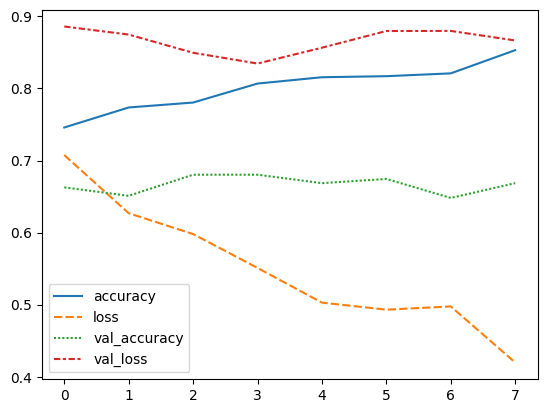

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(data=mobilenet_history.history)
plt.show()

In [41]:
gc.collect()

print("Training ResNet model...")
resnet_history = resnet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[resnet_checkpoint_callback, early_stopping_callback]
)


tf.keras.backend.clear_session()
gc.collect()



Training ResNet model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4547 - loss: 1.4644
Epoch 1: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 542s 8s/step - accuracy: 0.4533 - loss: 1.4650 - val_accuracy: 0.3109 - val_loss: 1.4961
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2189 - loss: 1.5428
Epoch 2: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 576s 9s/step - accuracy: 0.2199 - loss: 1.5424 - val_accuracy: 0.3109 - val_loss: 1.4925
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2576 - loss: 1.5467
Epoch 3: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 556s 8s/step - accuracy: 0.2583 - loss: 1.5462 - val_accuracy: 0.3109 - val_loss: 1.5068
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2977 - loss: 1.5546
Epoch 4: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 562s 8s/step - accuracy: 0.2980 - loss: 1.5543 - val_accuracy: 0

0

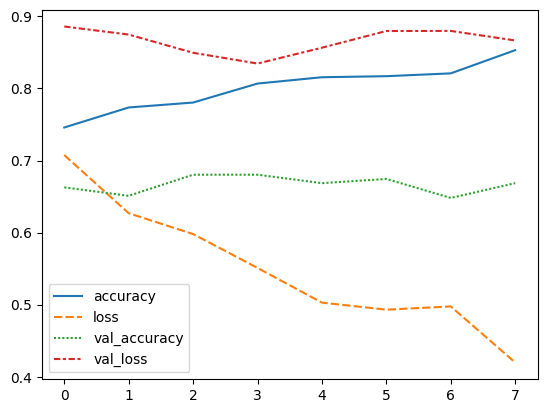

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(data=mobilenet_history.history)
plt.show()

In [ ]:

print("\nTraining InceptionV3 model...")
inceptionv3_history = inceptionv3_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[inceptionv3_checkpoint_callback, early_stopping_callback]
)


Training InceptionV3 model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.3051 - loss: 1.8995
Epoch 1: val_accuracy did not improve from 0.62170
65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 670ms/step - accuracy: 0.3050 - loss: 1.8971 - val_accuracy: 0.3871 - val_loss: 1.3609
Epoch 2/10
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.3551 - loss: 1.5537
Epoch 2: val_accuracy did not improve from 0.62170
65/65 ━━━━━━━━━━━━━━━━━━━━ 60s 444ms/step - accuracy: 0.3541 - loss: 1.5536 - val_accuracy: 0.4194 - val_loss: 1.4170
Epoch 3/10
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.2360 - loss: 1.5373
Epoch 3: val_accuracy did not improve from 0.62170
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 511ms/step - accuracy: 0.2377 - loss: 1.5373 - val_accuracy: 0.4223 - val_loss: 1.4190
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.2716 - loss: 1.5539
Epoch 4: val_accuracy did not improve from 0.62170
65/65 ━━━━━━━━━━━━━━━━━━━━ 39s 480ms/step - accuracy: 0.2722 - loss

In [ ]:
inceptionv3_train_results = inceptionv3_model.evaluate(train_dataset)

65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 480ms/step - accuracy: 0.2236 - loss: 1.5139


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.lineplot(data=inceptionv3_history.history)
plt.show()

NameError: name 'inceptionv3_history' is not defined

In [ ]:
inceptionv3_test_results = inceptionv3_model.evaluate(test_dataset)

print(f"InceptionV3 Test Loss: {inceptionv3_test_results[0]:.4f}")
print(f"InceptionV3 Test Accuracy: {inceptionv3_test_results[1]:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.5713 - loss: 1.2286
InceptionV3 Test Loss: 1.3750
InceptionV3 Test Accuracy: 0.5121


In [ ]:

print("\nEvaluating ResNet model on the test dataset...")
resnet_test_results = resnet_model.evaluate(test_dataset)

print(f"ResNet Test Loss: {resnet_test_results[0]:.4f}")
print(f"ResNet Test Accuracy: {resnet_test_results[1]:.4f}")

In [ ]:


print("\nEvaluating MobileNetV2 model on the test dataset...")
mobilenet_test_results = mobilenet_model.evaluate(test_dataset)

print(f"MobileNetV2 Test Loss: {mobilenet_test_results[0]:.4f}")
print(f"MobileNetV2 Test Accuracy: {mobilenet_test_results[1]:.4f}")

print("\nEvaluating InceptionV3 model on the test dataset...")


In [38]:

print("\nTraining MobileNetV2 model...")
mobilenet_history = mobilenet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[mobilenet_checkpoint_callback, early_stopping_callback]
)



Training MobileNetV2 model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3943 - loss: 1.4801
Epoch 1: val_accuracy did not improve from 0.68035
65/65 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.3935 - loss: 1.4805 - val_accuracy: 0.6158 - val_loss: 0.9446
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4068 - loss: 1.5218
Epoch 2: val_accuracy did not improve from 0.68035
65/65 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.4063 - loss: 1.5220 - val_accuracy: 0.6628 - val_loss: 0.9111
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2553 - loss: 1.5486
Epoch 3: val_accuracy did not improve from 0.68035
65/65 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.2561 - loss: 1.5485 - val_accuracy: 0.6334 - val_loss: 0.9278
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2304 - loss: 1.5537
Epoch 4: val_accuracy did not improve from 0.68035
65/65 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.2314 - loss: 1.5534 - val_accur

KeyboardInterrupt: 

In [39]:
import gc
import tensorflow as tf

gc.collect()

print("\nTraining ResNet model...")
resnet_history = resnet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[resnet_checkpoint_callback, early_stopping_callback]
)







Training ResNet model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4071 - loss: 1.6247
Epoch 1: val_accuracy improved from -inf to 0.31085, saving model to /content/drive/MyDrive/best_resnet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 580s 9s/step - accuracy: 0.4063 - loss: 1.6234 - val_accuracy: 0.3109 - val_loss: 2.2224
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3600 - loss: 1.5375
Epoch 2: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 616s 9s/step - accuracy: 0.3598 - loss: 1.5374 - val_accuracy: 0.3109 - val_loss: 1.6367
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2906 - loss: 1.5837
Epoch 3: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 528s 8s/step - accuracy: 0.2912 - loss: 1.5831 - val_accuracy: 0.3109 - val_loss: 1.5345
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3448 - loss: 1.5446
Epoch 4: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 570s 9s/step - accuracy: 0.3451 - loss: 1.5440 - val_accuracy: 0.3109 - val_loss: 1.5752
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3025 - loss: 1.5576
Epoch 5: val_accuracy did not improve from 0.31085


KeyboardInterrupt: 

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

print("\nTraining InceptionV3 model...")
inceptionv3_history = inceptionv3_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[inceptionv3_checkpoint_callback, early_stopping_callback]
)

**Reasoning**:
The error `ValueError: Argument output must have rank (ndim) target.ndim - 1. Received: target.shape=(None,), output.shape=(None, 3, 3, 5)` indicates that the output shape of the ResNet model is not compatible with the sparse categorical crossentropy loss function. This is likely due to the MaxPooling2D layer applied after the base model output, which results in a 4D tensor output instead of a 2D tensor suitable for the dense layer. The model architecture needs to be adjusted to flatten or pool the output before the final dense layer.



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import gc

# Rebuild the ResNet model with GlobalAveragePooling2D
base_resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers
for layer in base_resnet_model.layers:
    layer.trainable = False

x = base_resnet_model.output

# Replace MaxPooling2D with GlobalAveragePooling2D
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(512, activation='relu')(x)

x = layers.Dropout(0.5)(x)

# Update the output layer to have the number of selected categories
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)

resnet_model = models.Model(inputs=base_resnet_model.input, outputs=predictions)

resnet_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

print("\nRebuilt and compiled ResNet model with GlobalAveragePooling2D.")
resnet_model.summary()

# Now, retrain the models
gc.collect()

print("\nTraining ResNet model...")
resnet_history = resnet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[resnet_checkpoint_callback, early_stopping_callback]
)

tf.keras.backend.clear_session()
gc.collect()

print("\nTraining MobileNetV2 model...")
mobilenet_history = mobilenet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[mobilenet_checkpoint_callback, early_stopping_callback]
)

tf.keras.backend.clear_session()
gc.collect()

print("\nTraining InceptionV3 model...")
inceptionv3_history = inceptionv3_model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[inceptionv3_checkpoint_callback, early_stopping_callback]
)


Rebuilt and compiled ResNet model with GlobalAveragePooling2D.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 1,051,653 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Training ResNet model...
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 530ms/step - accuracy: 0.3791 - loss: 1.6897
Epoch 1: val_accuracy improved from -inf to 0.15249, saving model to /content/drive/MyDrive/best_resnet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 64s 737ms/step - accuracy: 0.3784 - loss: 1.6892 - val_accuracy: 0.1525 - val_loss: 1.5619
Epoch 2/10
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.3794 - loss: 1.5556
Epoch 2: val_accuracy improved from 0.15249 to 0.31085, saving model to /content/drive/MyDrive/best_resnet_model.weights.h5


65/65 ━━━━━━━━━━━━━━━━━━━━ 37s 567ms/step - accuracy: 0.3792 - loss: 1.5554 - val_accuracy: 0.3109 - val_loss: 1.5212
Epoch 3/10
64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.2338 - loss: 1.5768
Epoch 3: val_accuracy did not improve from 0.31085
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 546ms/step - accuracy: 0.2359 - loss: 1.5756 - val_accuracy: 0.3109 - val_loss: 1.4957
Epoch 4/10
14/65 ━━━━━━━━━━━━━━━━━━━━ 28s 560ms/step - accuracy: 0.2173 - loss: 1.5656

KeyboardInterrupt: 

Let's visualize the distribution of images per category using bar plots.

## Define VGGNet model

### Subtask:
Build a VGGNet model using pre-trained weights (e.g., VGG16, VGG19) and add custom layers for your classification task.

**Reasoning**:
Build the VGGNet model by loading the pre-trained weights, adding custom layers, and printing the summary.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

# Define VGG16 model
base_vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers initially
for layer in base_vgg_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_vgg_model.output
x = layers.Flatten()(x) # Flatten the output of the convolutional layers
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(len(selected_category_names), activation='softmax')(x)

vgg_model = models.Model(inputs=base_vgg_model.input, outputs=predictions)

# Compile the model
vgg_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print("\nVGGNet model defined and compiled.")
vgg_model.summary()

## Define Callbacks

### Subtask:
Define ModelCheckpoint and EarlyStopping callbacks for model training.

**Reasoning**:
Define ModelCheckpoint callbacks to save the best weights for each model during training and an EarlyStopping callback to stop training when the validation accuracy stops improving.

## Compile Models

### Subtask:
Compile the ResNet, MobileNetV2, and InceptionV3 models with appropriate optimizers, loss functions, and metrics.

**Reasoning**:
Compile each of the defined models using the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric.